In [1]:
### fitting the LDS with the neu
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from importlib import reload
from math import radians
def chol(cov):
    """
    cov = a@a.T
    return a
    """
    return torch.linalg.cholesky(cov)

from VAE_project_lib.sym_blk_tridiag_inv import *
from VAE_project_lib.blk_tridiag_chol_tools import *
from VAE_project_lib.LDS import *

In [2]:
#####################################
# 1D drifting latent dynamics with Poisson noise
#####################################
class AddConstant(nn.Module):
    def __init__(self, constant_value):
        super(AddConstant, self).__init__()
        self.constant = constant_value

    def forward(self, x):
        return x + self.constant

xdim=50
zdim=1


noise_amp=0.05
TeacherGenerativeParams = {
    'mu1': torch.zeros(zdim), #need to optimize
    'Q1chol': 2*torch.eye(zdim), #optimize chol(Q1)
    'A': 0.8*torch.eye(zdim), #need to optimize 
    'Qchol': 2*torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 25),nn.Tanh(),nn.Linear(25,xdim),Exp()),
    'Rchol':torch.diag(noise_amp*torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
}

StudentGenerativeParams1= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 40),nn.Tanh(),nn.Linear(40,xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
                    }

StudentRecognitionParams1 = {
    "NN_Mu": NN_5l_new(3*xdim,[200,200,200,200,60],zdim,diag_drift=True),
    "NN_Lambda": NN_2l(xdim,25,zdim*zdim),
    "NN_LambdaX": NN_2l(xdim*2,25,zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}



StudentGenerativeParams2= {
    'mu1': torch.randn(zdim), #need to optimize
    'Q1chol': torch.eye(zdim), #optimize chol(Q1)
    'A': torch.randn(zdim,zdim), #need to optimize 
    'Qchol': torch.eye(zdim), #optimize chol(Q)
    'NN': nn.Sequential(nn.Linear(zdim, 40),nn.Tanh(),nn.Linear(40,xdim),Exp()),
    'Rchol':torch.diag(torch.eye(xdim)),
    'ProbFunc': None, 
    'ProbPara': None,
    'zdim':zdim, 
    'xdim': xdim
                    }

StudentRecognitionParams2 = {
    "NN_Mu": NN_5l_new(3*xdim,[200,200,200,200,60],zdim,diag_drift=True),
    "NN_Lambda": NN_2l(xdim,25,zdim*zdim),
    "NN_LambdaX": NN_2l(xdim*2,25,zdim*zdim,offdiag=True),
    "xdim":xdim,
    "zdim":zdim
}

#####################################
# GENERATING TRAINING DATA FROM TEACHER
#####################################
T = 100
trail_num=400
pdatasx = torch.zeros(trail_num,T,xdim)
pdatasz = torch.zeros(trail_num,T,zdim)

teacherpLDS = pLDS(TeacherGenerativeParams)
for i in range(trail_num):
    x,z = teacherpLDS.xsample(T,returnz=True)
    pdatasx[i] = x
    pdatasz[i] = z
    
gdatasx = torch.zeros(trail_num,T,xdim)
gdatasz = torch.zeros(trail_num,T,zdim)

teachergLDS = LDS(TeacherGenerativeParams)
for i in range(trail_num):
    x,z = teachergLDS.xsample(T,returnz=True)
    gdatasx[i] = x
    gdatasz[i] = z

In [3]:
myvae_gau = VAE(StudentGenerativeParams1,StudentRecognitionParams1,LDS,inverse_LDS,beta=1)
myvae_poi = VAE(StudentGenerativeParams2,StudentRecognitionParams2,pLDS,inverse_LDS,beta=1)

In [4]:
#######################################
# TRAINING VAE
#######################################
optimizer = torch.optim.Adam(myvae_gau.parameters(), lr=0.001)
train_vae(myvae_gau, gdatasx, optimizer, device="cpu", epochs=15)
optimizer = torch.optim.Adam(myvae_poi.parameters(), lr=0.001)
train_vae(myvae_poi, pdatasx, optimizer, device="cpu", epochs=15)

Epoch [1/15], Loss: -1013.6964
Epoch [2/15], Loss: -7266.6245
Epoch [3/15], Loss: -11618.0840
Epoch [4/15], Loss: -11775.2099
Epoch [5/15], Loss: -11849.7122
Epoch [6/15], Loss: -11850.0724
Epoch [7/15], Loss: -11870.4605
Epoch [8/15], Loss: -11887.3557
Epoch [9/15], Loss: -11900.9254
Epoch [10/15], Loss: -11927.1868
Epoch [11/15], Loss: -11898.0793
Epoch [12/15], Loss: -11886.0615
Epoch [13/15], Loss: -11938.2970
Epoch [14/15], Loss: -11923.5600
Epoch [15/15], Loss: -11937.3227
Epoch [1/15], Loss: 6884.0292
Epoch [2/15], Loss: 6805.1672
Epoch [3/15], Loss: 6779.2314
Epoch [4/15], Loss: 6752.5212
Epoch [5/15], Loss: 6732.2559
Epoch [6/15], Loss: 6723.0380
Epoch [7/15], Loss: 6719.0769
Epoch [8/15], Loss: 6718.5502
Epoch [9/15], Loss: 6718.5711
Epoch [10/15], Loss: 6716.8208
Epoch [11/15], Loss: 6717.7814
Epoch [12/15], Loss: 6717.2984
Epoch [13/15], Loss: 6717.1338
Epoch [14/15], Loss: 6717.7174
Epoch [15/15], Loss: 6716.6195


Text(0.5, 1.0, 'Poisson')

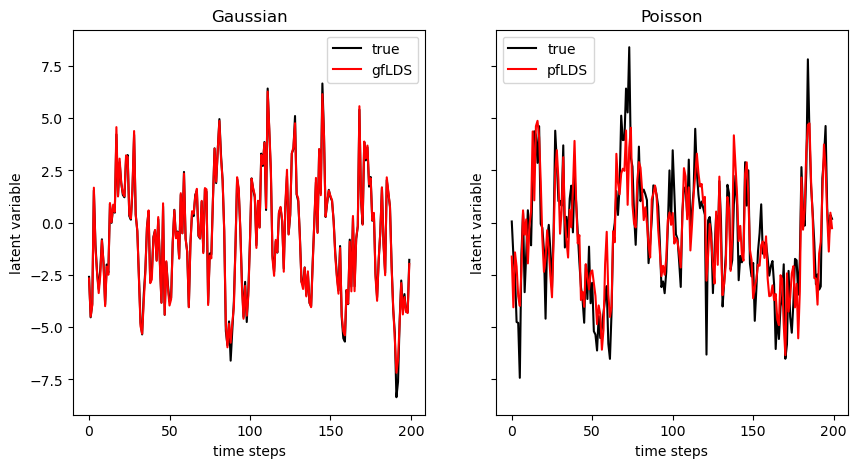

In [9]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

#Gaussian
x,z = teachergLDS.xsample(200,returnz=True)
vae_z=myvae_gau.Recognition.encode(x)
prj_m = z_projection_single(vae_z,z)
vae_z = proj(vae_z,prj_m)
true_z = z
ax[0].plot(true_z[:,0],color="k",alpha=1,label="true")
ax[0].plot(vae_z[:,0],color="r",alpha=1,label="gfLDS")
ax[0].set_xlabel("time steps")
ax[0].set_ylabel("latent variable")
ax[0].legend()
ax[0].set_title("Gaussian")

#Possion
x,z = teacherpLDS.xsample(200,returnz=True)
vae_z=myvae_poi.Recognition.encode(x)
prj_m = z_projection_single(vae_z,z)
vae_z = proj(vae_z,prj_m)
true_z = z
ax[1].plot(true_z[:,0],color="k",alpha=1,label="true")
ax[1].plot(vae_z[:,0],color="r",alpha=1,label="pfLDS")
ax[1].set_xlabel("time steps")
ax[1].set_ylabel("latent variable")
ax[1].legend()
ax[1].set_title("Poisson")
